!pip install --no-cache-dir --upgrade git+https://github.com/Evfro/polara.git@develop#egg=polara  
!pip install ipypb

In [1]:
import numpy as np
import pandas as pd

from polara import RecommenderData, SVDModel
from polara.recommender.models import RandomSampleEvaluationSVDMixin
from polara.recommender.data import RandomSampleEvaluationMixin
from polara.evaluation.pipelines import find_optimal_svd_rank

try:
    from ipypb import track
except ImportError:
    from tqdm.auto import tqdm as track

from dataprep import split_holdout, sample_unseen_interactions

---
The following setup is based on experiment description from the RecWalk paper:  
_"RecWalk: Nearly Uncoupled Random Walks for Top-N Recommendation"_; Athanasios N. Nikolakopoulos, George Karypis; WSDM '19.  
---

In [2]:
# randomization control
seed = 0
holdout_seed = 42 # to sample unseen items for holdout
# evaluation setitings
target_metric = 'hr'
svd_ranks = range(5, 101, 5)

Logged results (with kernel restarts):  
```python
seed = 0, holdout_seed = 42

sample_max_rated = True, rating_threshold = 0:  
hr=0.3874367045299028, arhr=0.17455565548148003
```

## Data preprocessing

In [3]:
full_data = pd.read_csv('./data/raw/yahoo_data_full.gz')

In [4]:
full_data.head(5)

,userid,itemid,is_holdout
0,346,1,False
1,385,1,False
2,517,1,False
3,538,1,False
4,651,1,False


In [5]:
rs = np.random.RandomState(seed)
tmp_train, holdout = split_holdout(  # test
    full_data,
    sample_max_rated = True,
    feedback = 'is_holdout',
    random_state = rs
)
train, validation = split_holdout( # validation
    tmp_train,
    sample_max_rated = False, # feedback is implicit
    random_state = rs
)

In [6]:
assert not train.is_holdout.any()
assert not validation.is_holdout.any()
assert holdout.is_holdout.all()

### unseen items sampling

In [7]:
validation_unseen = sample_unseen_interactions(
    full_data,
    train.itemid.unique(),
    seed=seed)
validation_unseen.head()

userid
346    [2654, 2621, 1317, 2944, 1618, 1617, 3291, 143...
385    [2183, 642, 2202, 1328, 2492, 707, 2276, 2064,...
517    [679, 1725, 608, 2369, 519, 2346, 1732, 3298, ...
538    [1753, 975, 2113, 3047, 1412, 2084, 1954, 2488...
651    [2013, 2011, 735, 2658, 1758, 3098, 3147, 435,...
dtype: object

In [8]:
assert not ( # verify train and validation are disjoint
    train
    .groupby('userid', sort=False)
    .itemid
    .apply(lambda x: x.isin(validation_unseen.loc[x.name]).any()).any()
)

## Data Model Specification

In [9]:
class RandomSampleEvaluationData(
    RandomSampleEvaluationMixin, RecommenderData
): pass

In [10]:
data = RandomSampleEvaluationData(
    train, userid='userid', itemid='itemid', feedback=None # implicit feedback
)

In [11]:
data.prepare_training_only()

Preparing data...
Done.
There are 390131 events in the training and 0 events in the holdout.


### setting holdout and unseen interctions

In [12]:
data.set_test_data(holdout=validation, holdout_size=1)

Done. There are 7307 events in the holdout.


In [13]:
data.set_unseen_interactions(validation_unseen)

In [14]:
data.unseen_interactions.head()

userid
0    [2653, 2620, 1316, 2943, 1617, 1616, 3290, 143...
1    [2182, 641, 2201, 1327, 2491, 706, 2275, 2063,...
2    [678, 1724, 607, 2368, 518, 2345, 1731, 3297, ...
3    [2012, 2010, 734, 2657, 1757, 3097, 3146, 434,...
4    [1204, 2001, 530, 1915, 716, 2103, 1319, 225, ...
Name: itemid, dtype: object

In [15]:
assert data.unseen_interactions.apply(len).eq(999).all()

## PureSVD evaluation

In [16]:
class RandomSampleEvaluationSVD(
    RandomSampleEvaluationSVDMixin, SVDModel
): pass

In [17]:
svd = RandomSampleEvaluationSVD(data)

### grid search on validation data

In [18]:
best_svd_rank, svd_scores = find_optimal_svd_rank(
    svd,
    svd_ranks,
    target_metric,
    metric_type = 'main',
    return_scores = True,
    iterator = track
)

 [████████████████████████████████████████████████████████████] 20/20 [00:49<00:02, 2.43s/it]

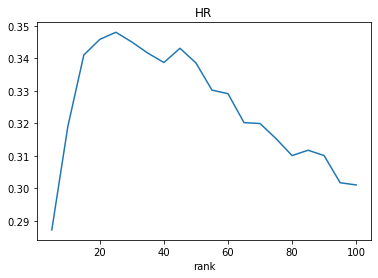

In [19]:
svd_scores.plot(title=target_metric.upper());

### evaluation on withheld data

In [20]:
# add validation data to train
data._data = data._data.append(validation, ignore_index=True)
data.prepare_training_only()

Preparing data...
Done.
There are 397438 events in the training and 0 events in the holdout.


In [21]:
data.set_test_data(holdout=holdout, holdout_size=1)

Done. There are 7307 events in the holdout.


In [22]:
holdout_unseen = sample_unseen_interactions(
    full_data,
    data.index.itemid.old.values, # ensure validation is added
    seed = holdout_seed
)

In [24]:
assert holdout_unseen.apply(len).eq(999).all()
assert not ( # verify train and holdout are disjoint
    data._data # take validation split into account
    .groupby('userid', sort=False)
    .itemid
    .apply(lambda x: x.isin(holdout_unseen.loc[x.name]).any()).any()
)

In [25]:
data.set_unseen_interactions(holdout_unseen)
assert data.unseen_interactions.apply(len).eq(999).all()

In [26]:
print(f'Optimal SVD rank: {best_svd_rank}')
svd.rank = best_svd_rank
svd.evaluate(metric_type='main')

Optimal SVD rank: 25
PureSVD model is not ready. Rebuilding.
PureSVD training time: 0.170s


[Relevance(hr=0.3874367045299028),
 Ranking(arhr=0.17455565548148003, mrr=0.17455565548148005)]